# 데이터 전처리 파이프라인
YOLO 기반 알약 탐지를 위한 데이터 정제 과정을 재현할 수 있도록 단계별 노트북을 구성했습니다.


## 0. 사전 준비
- NAS와 프로젝트 경로가 노트북과 동일하다고 가정합니다.
- 모든 스크립트는 `analysis/` 디렉터리에, 산출물은 `stage*_*/` 디렉터리에 저장됩니다.
- 아래 셀은 재현성을 위해 작성되어 있으며 필요 시 직접 실행하면 됩니다.


In [1]:
from pathlib import Path
from pprint import pprint
import json


In [2]:
PROJECT_ROOT = Path("/mnt/nas/jayden_code/Tablet-Detection-Private")
DATA_ROOT = Path("/mnt/nas/jayden_code/ai05-level1-project")
STAGE2_DIR = PROJECT_ROOT / "stage2_eda_artifacts"
STAGE3_DIR = PROJECT_ROOT / "stage3_dataset_artifacts"
STAGE4_DIR = PROJECT_ROOT / "stage4_yolo_dataset"
TRAIN_IMAGE_DIR = DATA_ROOT / "train_images"
TEST_IMAGE_DIR = DATA_ROOT / "test_images"


In [3]:
def count_images(folder: Path) -> int:
    return len(list(folder.glob("*.png")))

print(f"학습 이미지: {count_images(TRAIN_IMAGE_DIR)}장")
print(f"테스트 이미지: {count_images(TEST_IMAGE_DIR)}장")


학습 이미지: 1489장
테스트 이미지: 843장


## 1. EDA 및 중복 탐지
- `analysis/stage2_eda.py` 스크립트로 실행한 결과물을 확인합니다.
- 중복 이미지/라벨 유무, 박스 통계, 카테고리 정보를 분석했습니다.


In [4]:
summary_path = STAGE2_DIR / "reports" / "eda_summary.txt"
print(summary_path.read_text(encoding="utf-8"))


=== Stage 2 EDA Summary ===
총 어노테이션 JSON 파일 수: 4527
고유 학습 이미지 수: 1489
어노테이션 총 개수: 9052
고유 카테고리 수: 146

중복 이미지 파일명 건수: 1489
중복 image_id 건수: 1489
중복 annotation_id 건수: 3586
누락된 이미지 파일 건수: 0
어노테이션 이슈 건수: 0
카테고리 이름 불일치 건수: 0

바운딩 박스 면적 비율 통계:
  min: 0.014802
  q1: 0.034726
  median: 0.045988
  q3: 0.085090
  max: 0.218074
  mean: 0.063144

세로/가로 비율 이상치 수: 0
소형 면적 이상치 수(상위 50): 0
대형 면적 이상치 수(상위 50): 0

카테고리별 상위 10개 어노테이션 수:
  category_id 3482: 514
  category_id 51: 514
  category_id 3350: 240
  category_id 30: 240
  category_id 1899: 180
  category_id 1: 180
  category_id 2482: 172
  category_id 16: 172
  category_id 16547: 143
  category_id 5: 143


In [5]:
dup_file = STAGE2_DIR / "reports" / "duplicate_image_files.json"
if dup_file.exists():
    duplicates = json.loads(dup_file.read_text(encoding="utf-8"))
    print(f"중복 이미지 총 {len(duplicates)}건 중 일부 예시:")
    pprint(duplicates[:2])
else:
    print("중복 정보 파일이 존재하지 않습니다.")


중복 이미지 총 1489건 중 일부 예시:
[{'key': 'K-001900-010224-016551-031705_0_2_0_2_70_000_200.png',
  'occurrences': [{'height': 1280,
                   'image_id': 1417,
                   'source_json': '/mnt/nas/jayden_code/ai05-level1-project/train_annotations/K-001900-010224-016551-031705_json/K-001900/K-001900-010224-016551-031705_0_2_0_2_70_000_200.json',
                   'width': 976},
                  {'height': 1280,
                   'image_id': 1417,
                   'source_json': '/mnt/nas/jayden_code/ai05-level1-project/train_annotations/K-001900-010224-016551-031705_json/K-016551/K-001900-010224-016551-031705_0_2_0_2_70_000_200.json',
                   'width': 976},
                  {'height': 1280,
                   'image_id': 1417,
                   'source_json': '/mnt/nas/jayden_code/ai05-level1-project/train_annotations/K-001900-010224-016551-031705_json/K-031705/K-001900-010224-016551-031705_0_2_0_2_70_000_200.json',
                   'width': 976},
           

> **결론**: `train_annotations_merged.json`에서 이미지와 annotation ID가 중복 생성되어 있었으며,
> 개별 약품 폴더 JSON만 사용하도록 데이터 정제 전략을 수립했습니다.


## 2. 중복 제거 및 COCO 재구성
- 스크립트: `analysis/stage3_prepare_dataset.py`
- 이미지 파일명을 기준으로 중복 라벨을 통합하고, 새 `image_id`/`annotation_id`를 재부여합니다.
- 8:2 비율로 학습/검증 세트를 분할합니다.


In [6]:
# 재실행이 필요할 때만 주석을 해제하세요.
# !python analysis/stage3_prepare_dataset.py


In [7]:
prep_summary_path = STAGE3_DIR / "reports" / "preparation_summary.json"
prep_summary = json.loads(prep_summary_path.read_text(encoding="utf-8"))
pprint(prep_summary)


{'anomaly_count': 0,
 'conflict_counts': {},
 'image_annotation_stats': {'images_with_multiple_annotations': 1425,
                            'max_annotations_per_image': 4,
                            'max_sources_per_image': 4,
                            'mean_annotations_per_image': 3.0396239086635326,
                            'mean_sources_per_image': 3.0396239086635326,
                            'median_annotations_per_image': 3.0,
                            'min_annotations_per_image': 1,
                            'min_sources_per_image': 1},
 'random_seed': 2024,
 'split_ratio': {'train': 0.8, 'val': 0.19999999999999996},
 'total_annotations': 4526,
 'total_categories': 73,
 'total_images': 1489,
 'train_annotations': 3614,
 'train_images': 1191,
 'val_annotations': 912,
 'val_images': 298}


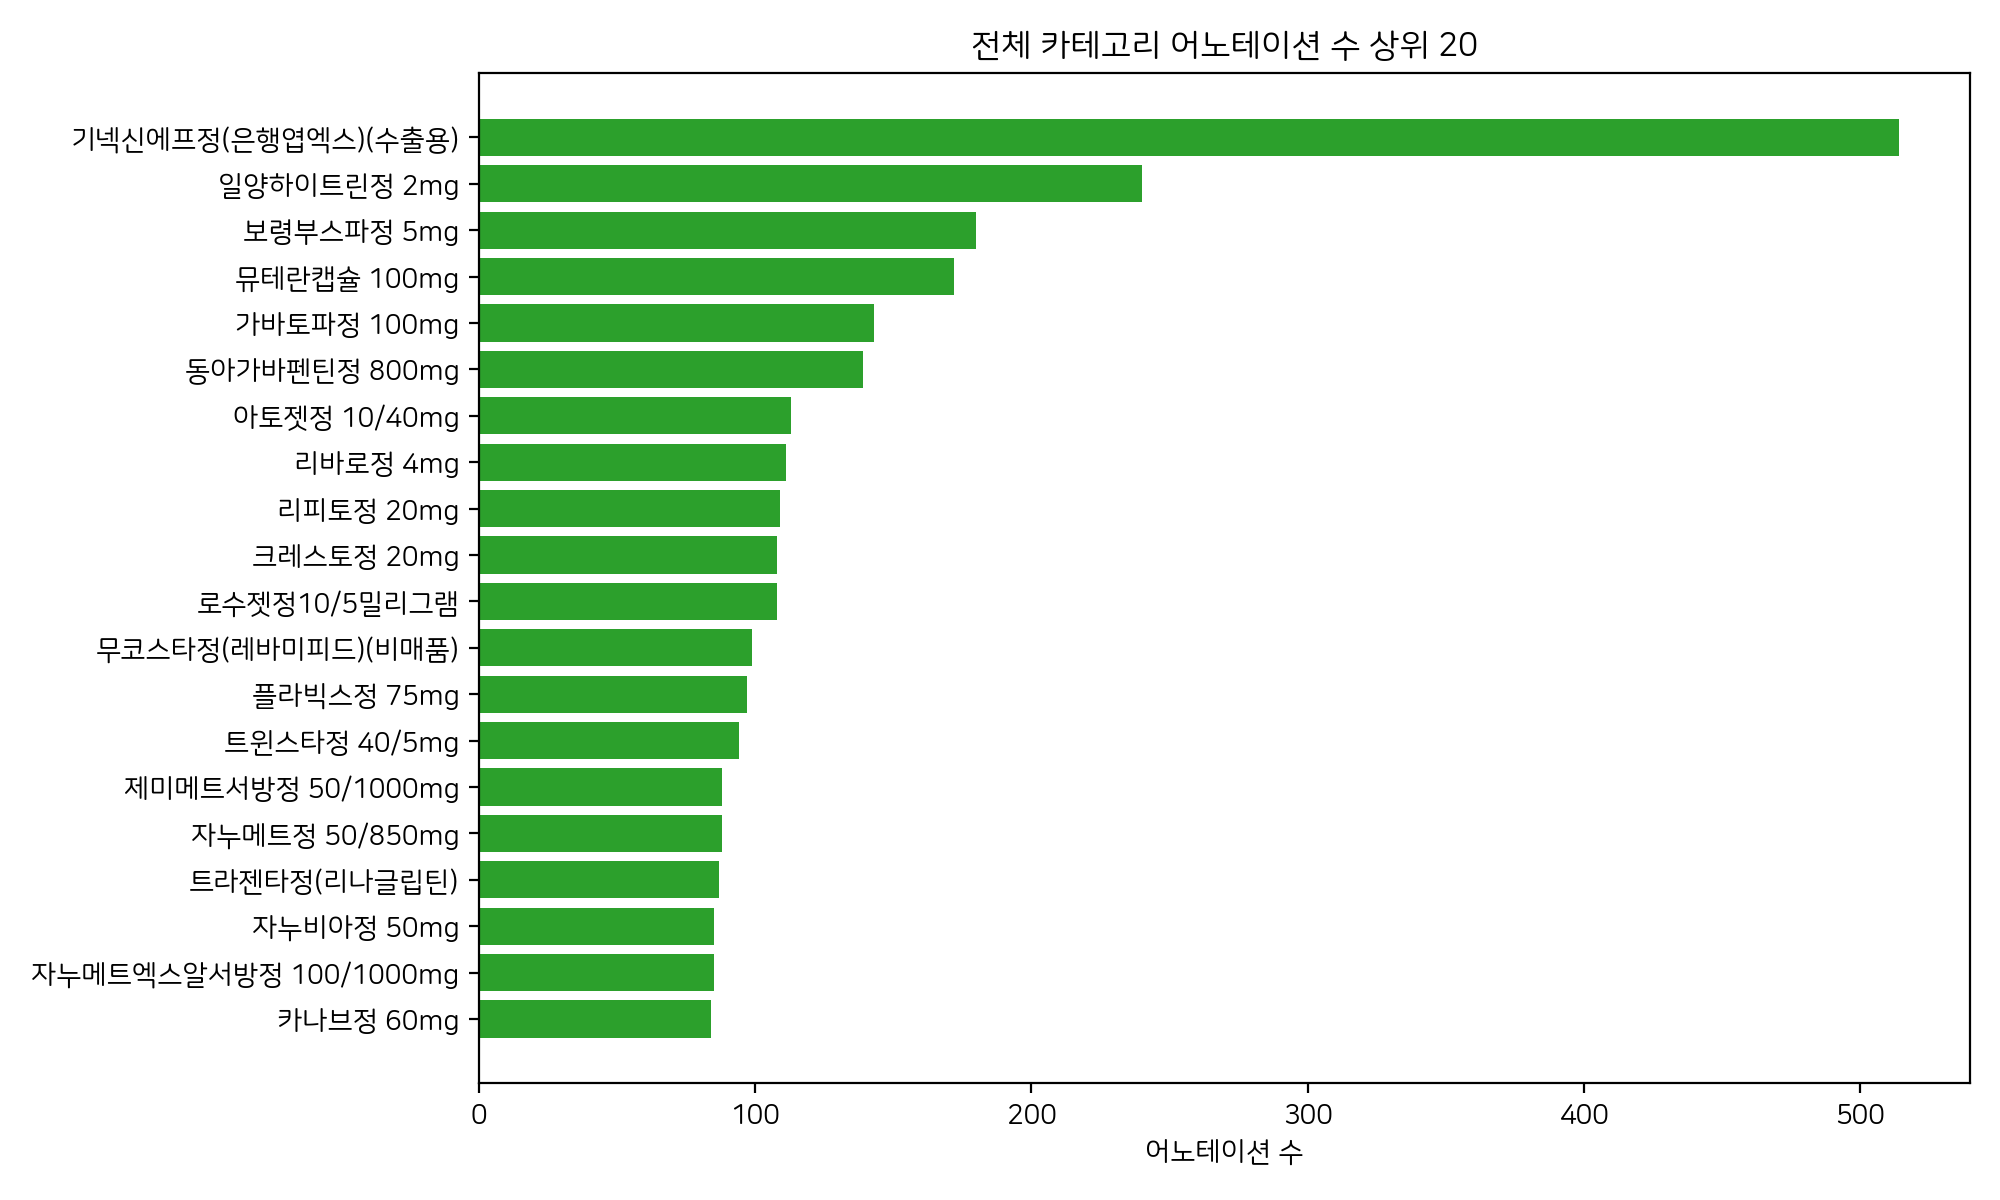

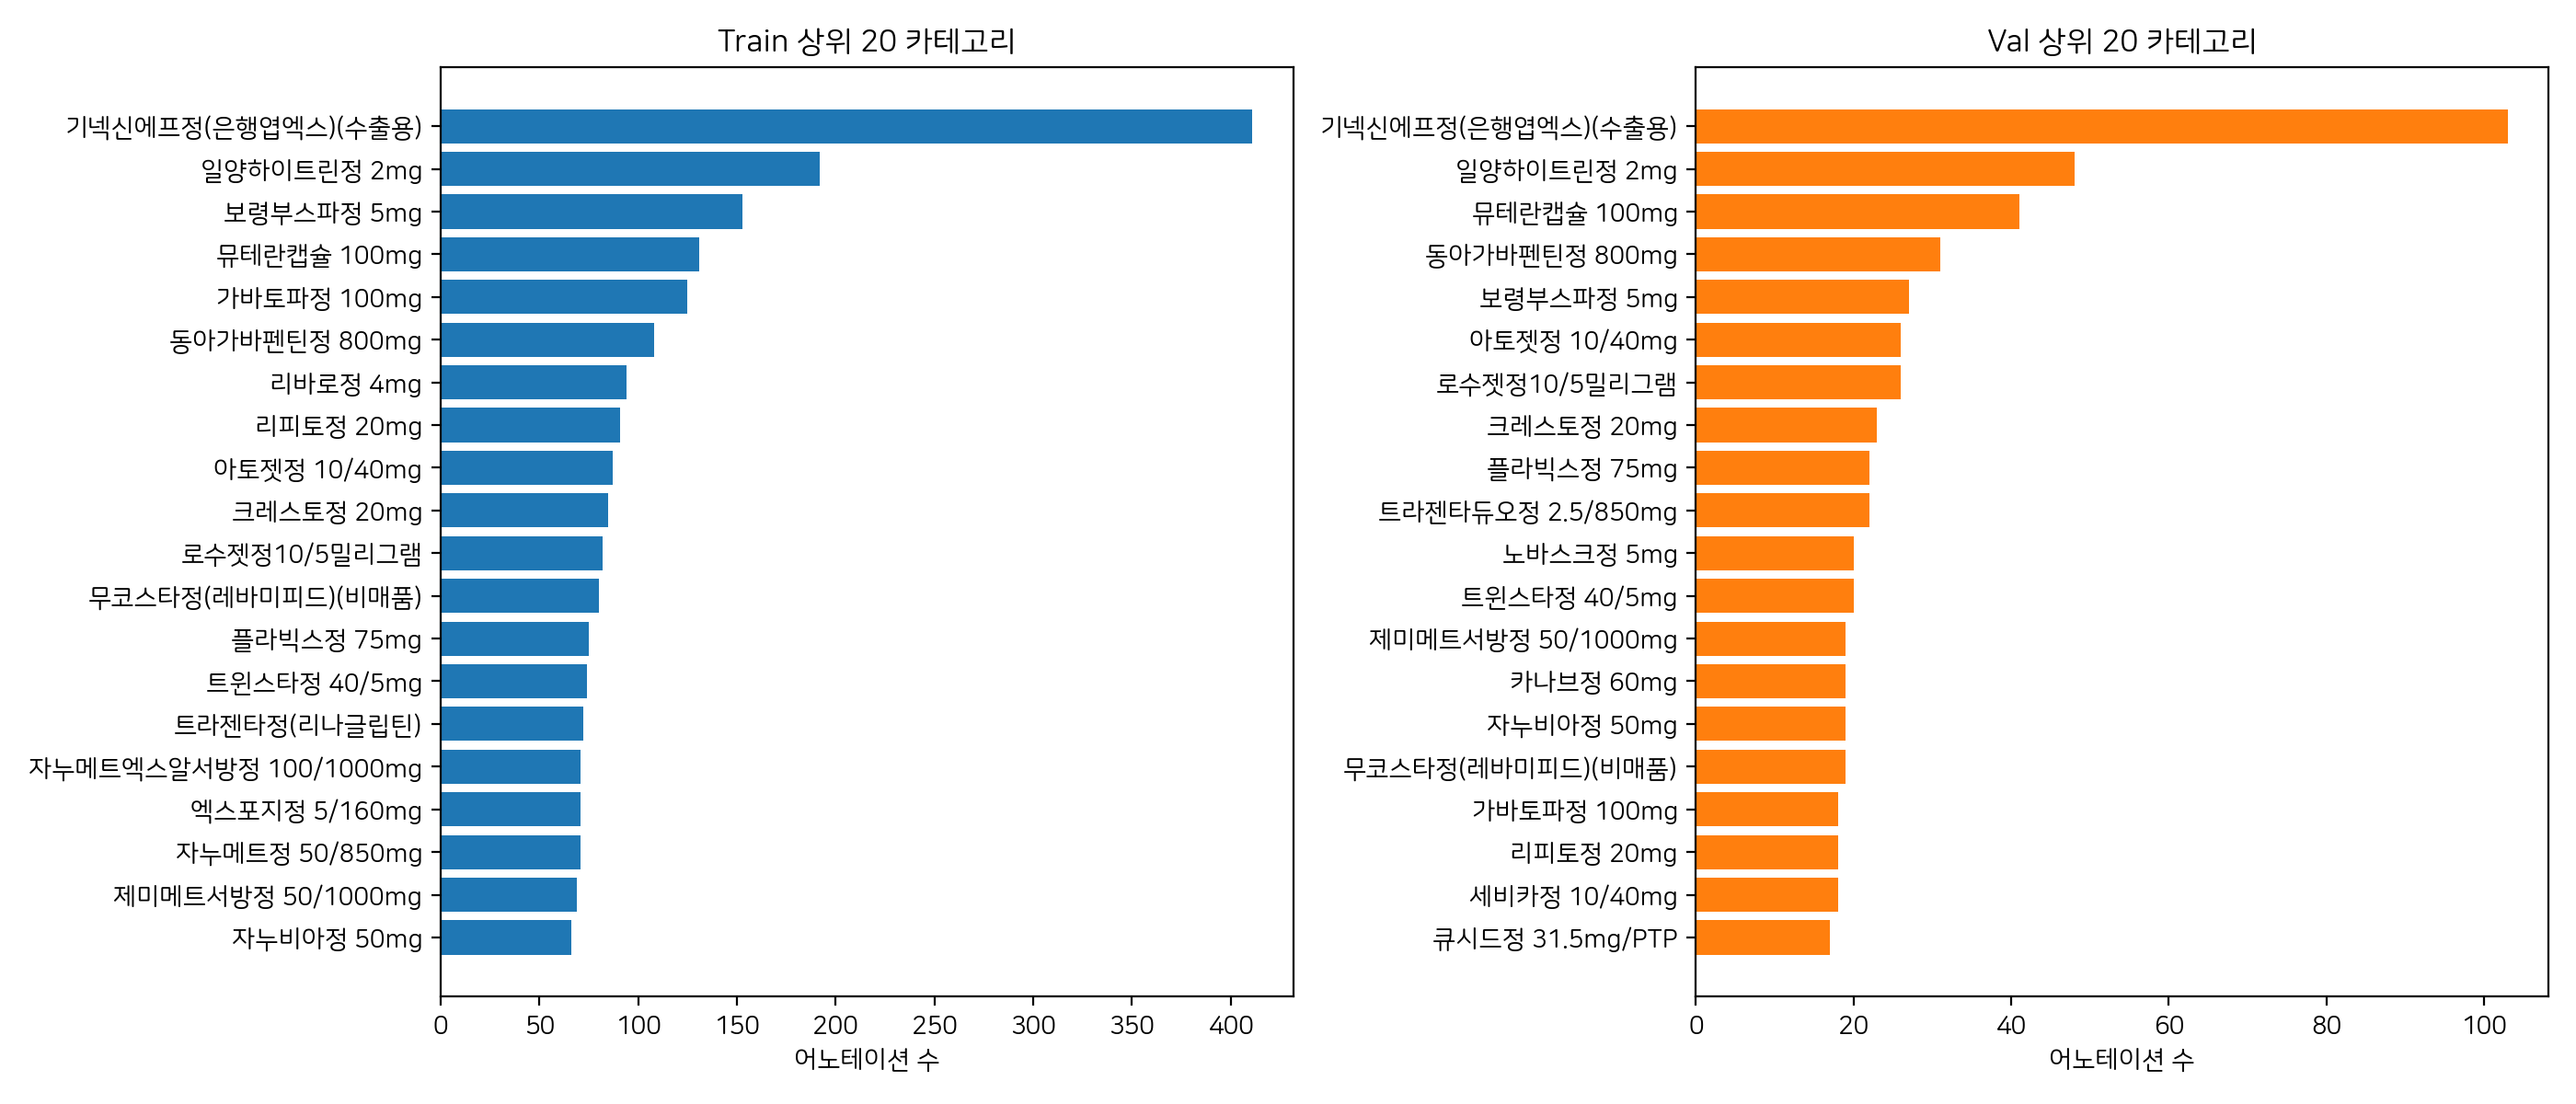

In [8]:
from IPython.display import Image, display
overall_fig = STAGE3_DIR / "figures" / "overall_category_distribution.png"
split_fig = STAGE3_DIR / "figures" / "split_category_distribution.png"
if overall_fig.exists():
    display(Image(filename=str(overall_fig)))
if split_fig.exists():
    display(Image(filename=str(split_fig)))


## 3. YOLO 형식 변환
- 스크립트: `analysis/stage4_convert_to_yolo.py`
- COCO 라벨을 YOLO txt 형식으로 변환하고, 이미지 심볼릭 링크와 클래스 매핑을 생성합니다.


In [9]:
# 필요 시 주석을 해제하여 변환을 재실행할 수 있습니다.
# !python analysis/stage4_convert_to_yolo.py


In [10]:
dataset_yaml = STAGE4_DIR / "dataset.yaml"
print(dataset_yaml.read_text(encoding="utf-8"))


path: /mnt/nas/jayden_code/Tablet-Detection-Private/stage4_yolo_dataset
train: /mnt/nas/jayden_code/Tablet-Detection-Private/stage4_yolo_dataset/images/train
val: /mnt/nas/jayden_code/Tablet-Detection-Private/stage4_yolo_dataset/images/val
nc: 73
names:
  0: 보령부스파정 5mg
  1: 뮤테란캡슐 100mg
  2: 일양하이트린정 2mg
  3: 기넥신에프정(은행엽엑스)(수출용)
  4: 무코스타정(레바미피드)(비매품)
  5: 알드린정
  6: 뉴로메드정(옥시라세탐)
  7: 타이레놀정500mg
  8: 에어탈정(아세클로페낙)
  9: 삼남건조수산화알루미늄겔정
  10: 타이레놀이알서방정(아세트아미노펜)(수출용)
  11: 삐콤씨에프정 618.6mg/병
  12: 조인스정 200mg
  13: 쎄로켈정 100mg
  14: 리렉스펜정 300mg/PTP
  15: 아빌리파이정 10mg
  16: 자이프렉사정 2.5mg
  17: 다보타민큐정 10mg/병
  18: 써스펜8시간이알서방정 650mg
  19: 에빅사정(메만틴염산염)(비매품)
  20: 리피토정 20mg
  21: 크레스토정 20mg
  22: 가바토파정 100mg
  23: 동아가바펜틴정 800mg
  24: 오마코연질캡슐(오메가-3-산에틸에스테르90)
  25: 란스톤엘에프디티정 30mg
  26: 리리카캡슐 150mg
  27: 종근당글리아티린연질캡슐(콜린알포세레이트) 
  28: 콜리네이트연질캡슐 400mg
  29: 트루비타정 60mg/병
  30: 스토가정 10mg
  31: 노바스크정 5mg
  32: 마도파정
  33: 플라빅스정 75mg
  34: 엑스포지정 5/160mg
  35: 펠루비정(펠루비프로펜)
  36: 아토르바정 10mg
  37: 라비에트정 20mg
  38: 리피로

## 4. 요약
- 중복 이미지 제거 및 고유 이미지 1,489장 확보
- 학습/검증(8:2) 분할과 카테고리 분포 확인
- YOLO 학습에 바로 사용할 수 있는 라벨·이미지·클래스 매핑 준비 완료
